# A Variational Autoencoder for Single Cell Transcriptomics in the CELLxGENE Dataset

This notebook complements the source code for a variational autoencoder (VAE) on the CELLxGENE Dataset. It is part of the course "Big Data Praktikum" at Leipzig University. In this notebook, we document our data pipeline and comment on decisions and experiences we made during the implementation. The notebook includes python code for illustrative purposes, but the main training pipeline is contained in seperate python scripts optimized for deployment to HPC infrastructure.

## Background

### Motivation



### Dataset



### Variational autoencoders

In [1]:
from autoCell.data_loader import SingleCellDataset
import src
import cellxgene_census
import anndata
import torch
import pandas as pd
import numpy as np

## Data loading and preprocessing

### Accessing the CELLxGENE Dataset

In [4]:
with cellxgene_census.open_soma() as census:
    adata = cellxgene_census.get_anndata(
        census, 
        "Homo sapiens",
        obs_coords=slice(0, 100),
        obs_value_filter="tissue_general == 'lung' and disease in ['normal','lung adenocarcinoma', 'squamous cell lung carcinoma', 'small cell lung carcinoma', 'non-small cell lung carcinoma', 'pleomorphic carcinoma', 'lung large cell carcinoma'] and is_primary_data == True",  # Specific tissue
        # var_value_filter="feature_name in ['GAPDH', 'ACTB']",  # Specific genes
        obs_column_names=["cell_type", "tissue", "disease"]  # Minimal metadata
    )

print(adata)

The "stable" release is currently 2025-01-30. Specify 'census_version="2025-01-30"' in future calls to open_soma() to ensure data consistency.


AnnData object with n_obs × n_vars = 0 × 61888
    obs: 'cell_type', 'tissue', 'disease', 'tissue_general', 'is_primary_data'
    var: 'soma_joinid', 'feature_id', 'feature_name', 'feature_type', 'feature_length', 'nnz', 'n_measured_obs'


### Preprocessing pipeline

TODO: Describe the data preparation that we've done, point out important code snippets

In [13]:
## Highlights from the preprocessing

In [15]:
## Generatate and describe dataset statistics

### Defining the PyTorch Dataset

In [2]:
from autoCell.data_loader import SingleCellDataset

data_file_path = "data.h5ad"
n_data_samples = 20_000
scale_factor = 1.0
latent_dim = 2
number_of_features = 2_000
use_variance = True
vae_processing = True

dataset = SingleCellDataset(
        file_path=data_file_path,
        cell_subset=list(range(n_data_samples)),
        log_transform=True, normalize=True,
        scale_factor=scale_factor,
        remove_outliers=[0.05, 0.95],
        select_n_genes=number_of_features,
        use_vae_preprocessing=vae_processing
    )

Using VAE-optimized preprocessing...
Dataset loaded: 20000 cells × 2000 genes


In [3]:
import torch

dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

## Defining the variational autoencoder

### Architecture

In [11]:
# Here code from the model initialization

### Definition of the ELBO

In [12]:
### Here code for the ELBO

### (Other architectural considerations - if needed)

## Training the variational autoencoder

### Training infrastructure

Describe the WandB setup, describe aspects needed for on-cluster training

### Parameterization of the training

Explain also how to run the script

### Training statistics

Show and interpret some of the charts from WandB

## Evaluation of the latent space

### Obtaining latent representation for the data samples

In [4]:
### Load model, forward pass data, store latent means
from src.vae import CellVAE
import torch

# Define model
model = CellVAE(input_dim=dataset.n_genes, latent_dim=latent_dim, use_variance=use_variance)

# Load weights
model.load_state_dict(torch.load('model.pth', map_location=torch.device('cpu')))

model.eval()

CellVAE(
  (encoder): Sequential(
    (0): Linear(in_features=2000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
  )
  (z_mean): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
  )
  (z_logvar): Sequential(
    (0): Linear(in_features=32, out_features=2, bias=True)
    (1): Softplus(beta=1.0, threshold=20.0)
  )
  (decoder_backbone): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=512, bias=True)
    (5): ReLU()
  )
  (value_head): Linear(in_features=512, out_features=2000, bias=True)
  (sparsity_head): Linear(in_features=512, out_features=2000, bias=True)
)

In [5]:
# obtain latent means on dataset

latent_means = []

with torch.no_grad():
    for idx, data in enumerate(dataloader):
        mu, _ = model.encode(data)
        latent_means.append(mu.cpu().numpy())  # ensure it's on CPU

# Stack all latent vectors into a single NumPy array
latent_array = np.vstack(latent_means)

# Create DataFrame with named columns: z1, z2, ..., zd
n_latents = latent_array.shape[1]
df_latent = pd.DataFrame(latent_array, columns=[f'z{i+1}' for i in range(n_latents)])

print(df_latent.head())


         z1        z2
0  0.458123 -0.403457
1  0.585549 -0.505295
2  0.416508 -0.372204
3  0.340296 -0.311072
4  0.503485 -0.439353


In [6]:
import numpy as np
import pandas as pd

# # Optional:
# # Simulate latent means
# latent_values = np.random.randn(n_data_samples, latent_dim)

# # Create DataFrame for latent values
# df_latent = pd.DataFrame(latent_values, columns=[f"z{i+1}" for i in range(latent_dim)])

label_df = dataset.get_cell_metadata()

labeled_latents = pd.concat([label_df.reset_index(drop=True), df_latent], axis=1)

print(labeled_latents.head())
print(labeled_latents.describe())

  tissue disease        z1        z2
0   lung  normal  0.458123 -0.403457
1   lung  normal  0.585549 -0.505295
2   lung  normal  0.416508 -0.372204
3   lung  normal  0.340296 -0.311072
4   lung  normal  0.503485 -0.439353
                 z1            z2
count  20000.000000  20000.000000
mean      -0.043579      0.030531
std        0.945950      0.726432
min       -1.470628     -2.748065
25%       -0.660400     -0.275627
50%       -0.138820      0.091933
75%        0.304306      0.525883
max        3.915713      1.170531


### Comparison: PCA

Create and compare PCA on Input Data vs Latent Rep.

In [7]:
import scanpy as sc 

adata = dataset.adata.copy()

sc.tl.pca(adata)

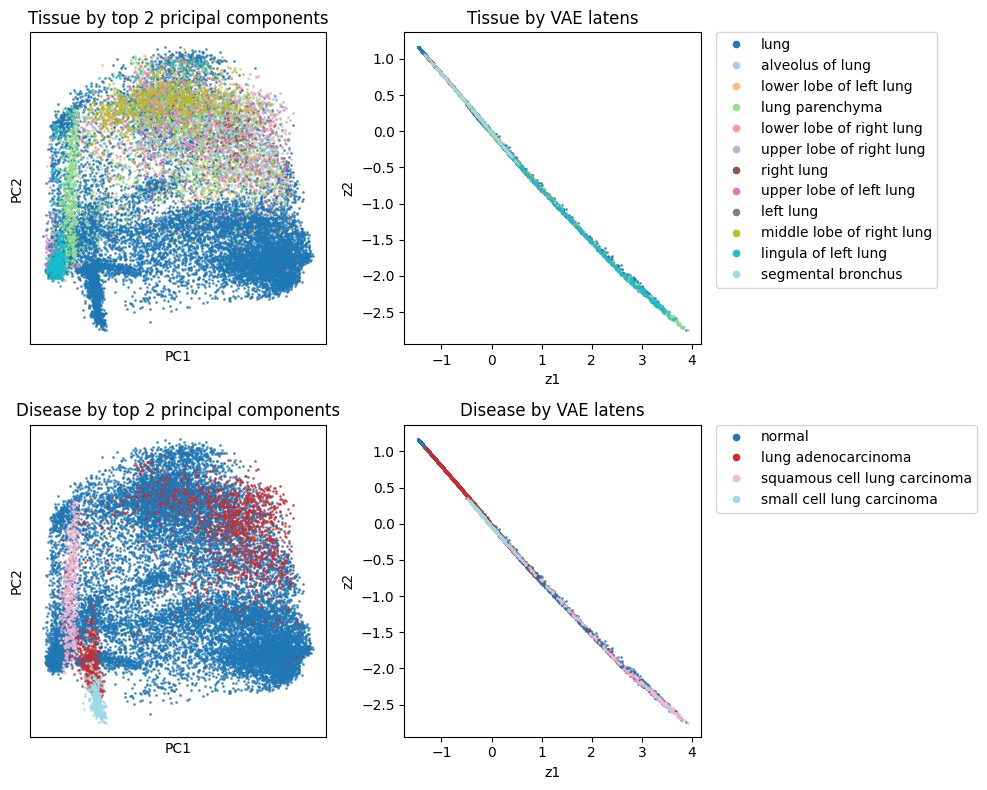

In [8]:
import scanpy as sc
import matplotlib.pyplot as plt
from src.utils import plot_latent_scatter

fig, axs = plt.subplots(2, 2, figsize=(10, 8)) 

df_pca = pd.DataFrame(adata.obsm['X_pca'], columns=[f'PC{i+1}' for i in range(adata.obsm['X_pca'].shape[1])])
labeled_pca = pd.concat([label_df.reset_index(drop=True), df_pca], axis=1)

plot_latent_scatter(labeled_pca, x='PC1', y='PC2', label_col='tissue', ax=axs[0,0], title='Tissue by top 2 pricipal components', dot_size=1, legend_dot_size=None, ticks=False)
plot_latent_scatter(labeled_pca, x='PC1', y='PC2', label_col='disease', ax=axs[1,0], title='Disease by top 2 principal components', dot_size=1, legend_dot_size=None, ticks=False)
plot_latent_scatter(labeled_latents, x='z1', y='z2', label_col='tissue', ax=axs[0,1], title='Tissue by VAE latens', dot_size=1, legend_dot_size=20, ticks=True)
plot_latent_scatter(labeled_latents, x='z1', y='z2', label_col='disease', ax=axs[1,1], title='Disease by VAE latens', dot_size=1, legend_dot_size=20, ticks=True)

plt.tight_layout()
plt.show()

### Comparison: UMAP

Create and compare UMAP on Input Data vs Latent Rep.

In [108]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

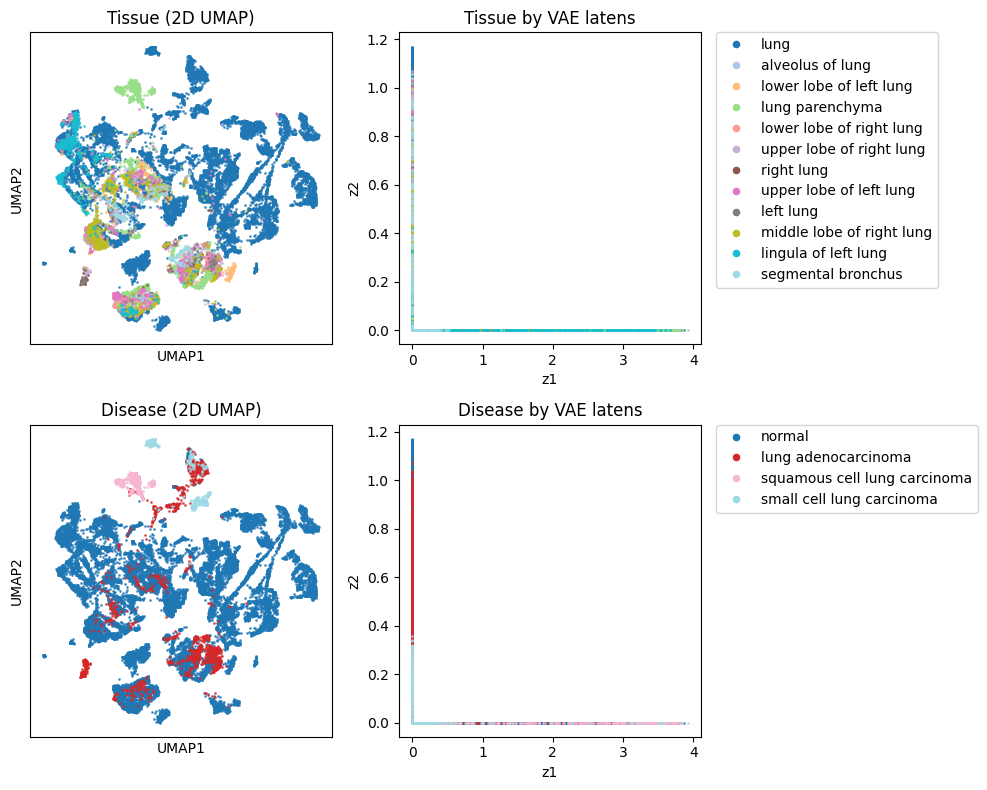

In [109]:
import scanpy as sc
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 2, figsize=(10, 8)) 

df_umap = pd.DataFrame(adata.obsm['X_umap'], columns=[f'UMAP{i+1}' for i in range(adata.obsm['X_umap'].shape[1])])
labeled_umap = pd.concat([label_df.reset_index(drop=True), df_umap], axis=1)

plot_latent_scatter(labeled_umap, x='UMAP1', y='UMAP2', label_col='tissue', ax=axs[0,0], title='Tissue (2D UMAP)', dot_size=1, legend_dot_size=None, ticks=False)
plot_latent_scatter(labeled_umap, x='UMAP1', y='UMAP2', label_col='disease', ax=axs[1,0], title='Disease (2D UMAP)', dot_size=1, legend_dot_size=None, ticks=False)
plot_latent_scatter(labeled_latents, x='z1', y='z2', label_col='tissue', ax=axs[0,1], title='Tissue by VAE latens', dot_size=1, legend_dot_size=20, ticks=True)
plot_latent_scatter(labeled_latents, x='z1', y='z2', label_col='disease', ax=axs[1,1], title='Disease by VAE latens', dot_size=1, legend_dot_size=20, ticks=True)

plt.tight_layout()
plt.show()

### Comparison: PCA + UMAP

Create and compare PCA + UMAP on Input Data vs Latent Rep.

In [112]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=50)
sc.tl.umap(adata)

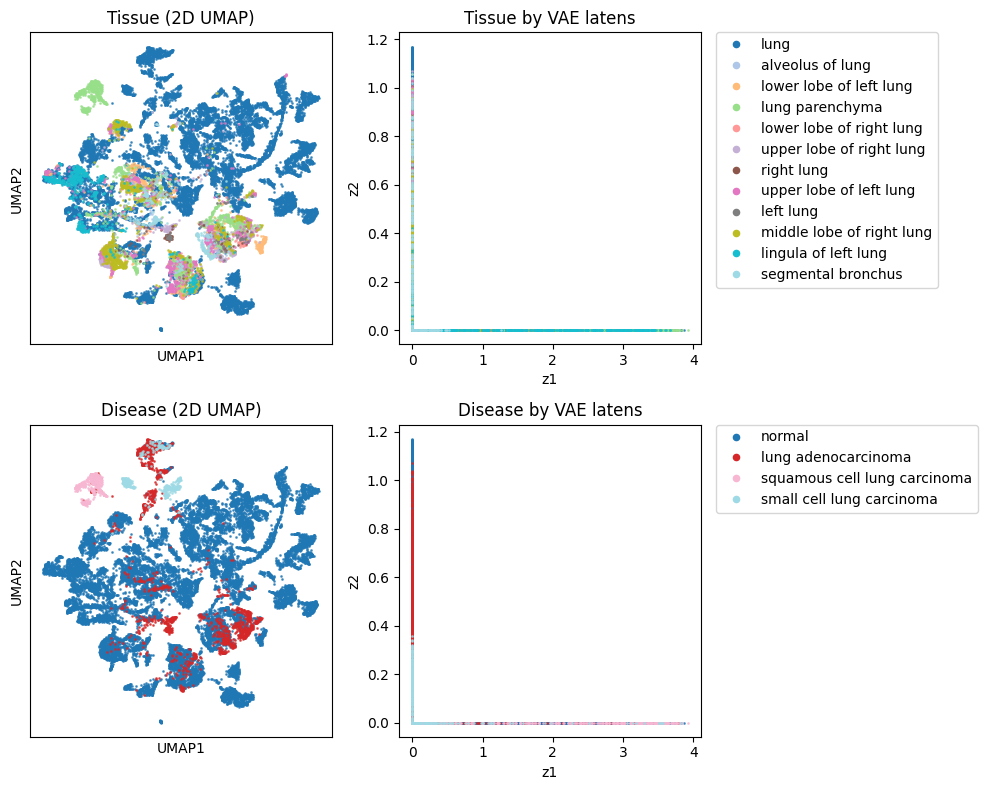

In [113]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8)) 

df_umap = pd.DataFrame(adata.obsm['X_umap'], columns=[f'UMAP{i+1}' for i in range(adata.obsm['X_umap'].shape[1])])
labeled_umap = pd.concat([label_df.reset_index(drop=True), df_umap], axis=1)

plot_latent_scatter(labeled_umap, x='UMAP1', y='UMAP2', label_col='tissue', ax=axs[0,0], title='Tissue (2D UMAP)', dot_size=1, legend_dot_size=None, ticks=False)
plot_latent_scatter(labeled_umap, x='UMAP1', y='UMAP2', label_col='disease', ax=axs[1,0], title='Disease (2D UMAP)', dot_size=1, legend_dot_size=None, ticks=False)
plot_latent_scatter(labeled_latents, x='z1', y='z2', label_col='tissue', ax=axs[0,1], title='Tissue by VAE latens', dot_size=1, legend_dot_size=20, ticks=True)
plot_latent_scatter(labeled_latents, x='z1', y='z2', label_col='disease', ax=axs[1,1], title='Disease by VAE latens', dot_size=1, legend_dot_size=20, ticks=True)

plt.tight_layout()
plt.show()

### Latent factor analysis

Vary only individual latents and see effect on cluster-colored umap

## Discussion

Concluding remarks on the results, further steps, ...